# Exploring random forest hyper-parameters using a League of Legends dataset

In [previous](http://www.trailofpapers.net/2015/10/playing-in-random-forests-in-league-of.html) [notebooks](http://www.trailofpapers.net/2015/11/influence-of-region-skill-and-patch-on.html), I have used random forests to predict who will win a game of League of Legends. In making those notebooks, I learned how important it is to optimize machine learning algorithms. In this notebook I am going to explore how random forest hyper-parameters like forest size, node size, and sample size can influence prediction accuracy. Near the end, I will do a grid search for optimal parameters, and finally compare random forest performance to Naive Bayes.

### Table of contents:
[Basic question](#basic)

[Forest size](#forestsize)

[Node size](#nodesize)

[Sample size](#sample)

[Grid search](#gridsearch)

[PCA](#PCA)

[Champions as features](#champions)

[Naive Bayes](#naivebayes)

## Load libraries and API key

In [1]:
import numpy as np
from src import feature_calc
import importlib
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import src.plotting as lol_plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# load sklearn packages
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [4]:
# load in 30,000 games from North America, and calculate features
working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\lolML'
os.chdir(working_dir)
with open('NA combined_df.pickle', 'rb') as pickle_file:
    na_timelines_df = pickle.load(pickle_file)
na_timelines_df = [feature_calc.calc_secondary_features(x) for x in na_timelines_df]
na_timelines_df = feature_calc.calc_second_diff(na_timelines_df)

In [6]:
# which features are important, taken from previous notebooks
important_col = ['blue_inhibs', 'blue_barons', 'drag_diff', 'first_baron', 'first_inhib',
                 'gold_diff', 'gold_diff_diff', 'kill_diff', 'kill_diff_diff', 'red_barons',
                 'red_inhibs', 'tower_diff']
timeline_end = 55
time_indices = np.arange(5, timeline_end, 5)

In [7]:
# plotting defaults
import matplotlib as mpl
mpl.rc('font', size=20)
mpl.rc('lines', linewidth=2)

<a id='basic'></a>
## The basic question

League of Legends is an online team game where two teams destroy each others' bases. Games usually take 30-40 minutes. I wanted to see whether, using machine learning, I could predict the winner of the game before it ended, say 5 minutes into the game.

As an example of this, here is how well a random forest model can predict the winner of games at 5 minute intervals. Snapshots of games were taken every 5 minutes, and the winner was predicted using features like gold or kills. As the game gets longer, the accuracy improves; at late times, however, accuracy goes down, since long games are inherently harder to predict.

In [8]:
rfc = RandomForestClassifier(n_jobs = 2, n_estimators = 25, max_features = 'sqrt')
def cross_validate_score(cur_df):
    return cross_validation.cross_val_score(rfc, cur_df[important_col], cur_df['winner'], cv=5, n_jobs = 2)

default_scores = [cross_validate_score(x) for x in na_timelines_df]

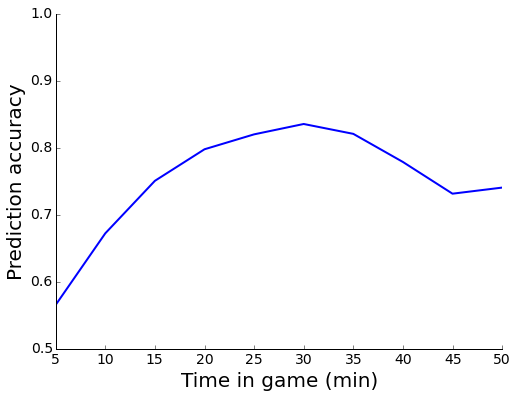

In [23]:
plt.figure(figsize = [8, 6])
plt.plot(time_indices, np.mean(default_scores, axis=1))
plt.ylim( 0.5, 1)
plt.xlabel('Time in game (min)')
plt.ylabel('Prediction accuracy')
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend(fontsize=14, frameon=False);

<a id='forestsize'></a>
## Impact of forest size on prediction accuracy

One obvious question when using random forests is, how many trees do you need in the forest? Here I am going to try forest sizes ranging from 1-50 trees, and see how it impacts accuracy. Note that I am using around a dozen features.

In the first cell, I perform the prediction on the accuracy for the data ten minutes into the game (using default random forest parameters). In the second cell, I plot performance as a function of trees. How does increasing the forest size impact the accuracy of the model?

In [14]:
forest_sizes = [1,5,10, 25, 50]
cur_df = na_timelines_df[1] # this is the 10 minute dataframe
def score_by_size(cur_size):
    size_forest = RandomForestClassifier(n_jobs = 2, n_estimators = cur_size, max_features = 'sqrt')
    return cross_validation.cross_val_score(size_forest, cur_df[important_col], cur_df['winner'], cv=4, n_jobs = 3)

size_scores = list(map(score_by_size, forest_sizes))

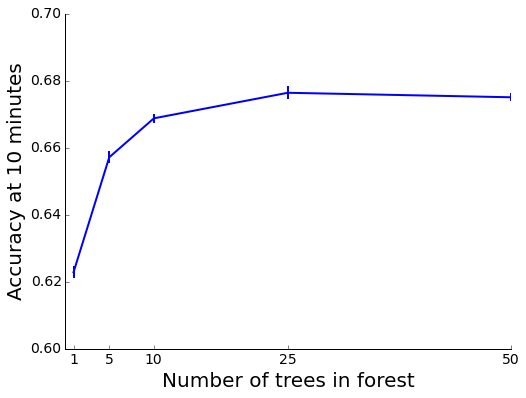

In [22]:
fig, ax = plt.subplots(1, figsize = [8, 6])
plt.errorbar(forest_sizes, np.mean(size_scores, 1), np.std(size_scores, 1) / np.sqrt(4), capsize = 0)
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy at 10 minutes')
plt.xlabel('Number of trees in forest')
ax.set_xticks(forest_sizes);
plt.ylim([0.6, 0.7]);

The performance of the random forest increases as you add more trees, and seems to plateau around 25 trees. It may be a good rule of thumb to use forests with a number of trees around double the number of features.

<a id='nodesize'></a>
## Impact of node size on prediction accuracy

In scikit-learn, with default parameters, each tree is built until each leaf of the tree is pure. However, there are options to adjust the minimum leaf size, and minimum split size. Here, I'm going to build forests using minimum split sizes ranging from 1-25.

In [17]:
def score_by_min_split(cur_min_split, cur_df):
    split_forest = RandomForestClassifier(n_jobs = -1, n_estimators = 25,
                                          max_features = 'sqrt', min_samples_split = cur_min_split)
    return cross_validation.cross_val_score(split_forest, cur_df[important_col], 
                                            cur_df['winner'], cv=5, n_jobs = -1)

min_samples_array = list(range(1, 27, 5))
min_split_scores = list(map(lambda x: score_by_min_split(x, na_timelines_df[1]), min_samples_array))

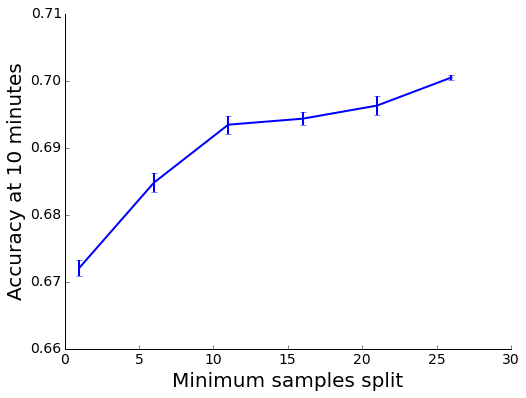

In [21]:
fig, ax = plt.subplots(1, figsize = [8, 6])
plt.errorbar(min_samples_array, np.mean(min_split_scores, 1), np.std(min_split_scores, 1) / np.sqrt(5))
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy at 10 minutes')
plt.xlabel('Minimum samples split')
plt.ylim([0.66, 0.71]);

The model gets slightly more accurate as you increase the minimum size of the split! With the default  parameters, each individual tree is overfit; the bagging and randomness of the forest cannot compensate for this. By allowing for some impure splits, the algorithm reduces overfitting on each individual tree, and is better able to generalize.  I could further explore this parameter, but later I'm going to do a grid search, so let's look at other parameters for now.

<a id='sample'></a>
## Sample size and model accuracy

In the previous examples, I was running cross-validated models using the entire dataset of 30,000 games. It's possible that with more games, we could get better accuracy; alternatively, it might only take a handful of games to predict the winner. To test that, I ran the classifier with different numbers of input games.

In [26]:
rfc = RandomForestClassifier(n_jobs = 2, n_estimators = 25, max_features = 'sqrt',
                             min_samples_leaf=10, min_samples_split=25)
def cross_validate_df(cur_df):
    return cross_validation.cross_val_score(rfc, cur_df[important_col], cur_df['winner'],
                                            cv=5, n_jobs = 2)

def calc_score_per_samples(timelines_df, n_samples):
    timelines_scores = [cross_validate_df(x.sample(min(x.shape[0], n_samples)) ) for x in timelines_df]
    return np.mean(timelines_scores, 1)

sample_range = np.arange(1000, 20000, 3000)
scores_per_samples = [ calc_score_per_samples(na_timelines_df, x) for x in sample_range]

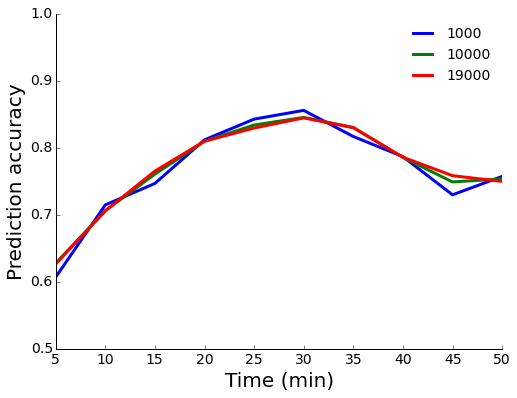

In [37]:
plt.figure(figsize = [8, 6])
for i, x in enumerate(scores_per_samples[::3]):
    plt.plot(time_indices, x, label = sample_range[3 * i])
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)')
plt.ylabel('Prediction accuracy')
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend(fontsize=14, frameon=False);

The model has a similar accuracy with 1,000, or 10,000 samples! There is just more variance with the 1000 sample model. It looks like we have a lot more data than we need.

<a id='gridsearch'></a>
## Grid search
We could make similar plots for every parameter, but it would be nice to systematically explore parameter spaces. Scikit-learn has two tools to do that, randomized search, and grid search (there is not, unfortunately, any monte-carlo markov models in the package).

Let's run a grid search over tree depth, node size, and leaf size. I will use 3-fold cross-validation as well. Note also, that I am going to stick with the default square root feature selection. I will use the dataframe for the ten minute timepoint.

In [38]:
from sklearn.grid_search import GridSearchCV
param_dict = { 'max_depth' : list(range(5, 16, 5)), 'min_samples_leaf': list(range(2,23,10)),
              'min_samples_split': list(range(10, 51, 10))}
grid_forest = GridSearchCV(RandomForestClassifier( n_estimators = 50, max_features = 'sqrt'),
                        param_grid = param_dict, cv = 3, n_jobs = 3)
grid_df = na_timelines_df[1] # dataframe at 10 minutes
grid_forest.fit(grid_df[important_col], grid_df['winner'])

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'min_samples_leaf': [2, 12, 22], 'min_samples_split': [10, 20, 30, 40, 50], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [39]:
grid_forest.best_params_

{'max_depth': 10, 'min_samples_leaf': 22, 'min_samples_split': 50}

The best forest had a maximum depth of 10, minimum leaf size of 22, and minimum node size of 50. Both the leaf and node size were at the maximum, so we could perform further grid searches. However, the accuracy gains were pretty small, so I will just use those parameters in the future.

In [52]:
better_forest = RandomForestClassifier(min_samples_leaf=20, min_samples_split=50, max_depth=10, n_estimators=25)


<a id='PCA'></a>
# Dimensionality reduction - PCA

I haven't talked much about the features, but I can tell you there is a lot of correlation between them. I should also say this section gets a little League of Legends wonky, so you can skip down to [Naive Bayes](#naivebayes)

To look at the collinearity, I used a pandas function, scatter_matrix().

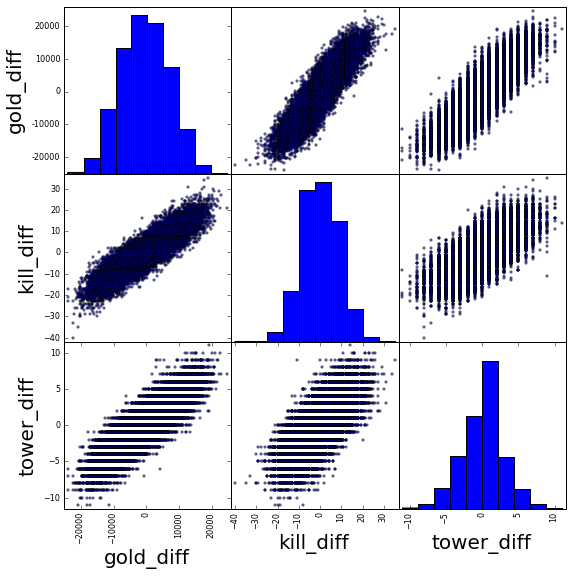

In [41]:
pd.tools.plotting.scatter_matrix(na_timelines_df[4][['gold_diff', 'kill_diff', 'tower_diff']], figsize = [9, 9]);

As you would expect, gold, kills, and tower differences are correlated.

Random forests are pretty resilient to multicollinearity, but I wanted to see if dimensionality reduction would help the model. To do that I used PCA. First we need to load the PCA library.

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=6)

PCA only works on continous data, so we need to select those features specifically.

In [50]:
scalar_col = np.array([x for x in important_col if x[0] != 'f'])
scalar_col

array(['blue_inhibs', 'blue_barons', 'drag_diff', 'gold_diff',
       'gold_diff_diff', 'kill_diff', 'kill_diff_diff', 'red_barons',
       'red_inhibs', 'tower_diff'], 
      dtype='<U14')

Now we can perform the PCA. I create a function to perform PCA on a dataframe. Then I perform PCA on the 25 minute dataframe.

In [48]:
def pca_lol_df(input_df, scalar_col):
    other_col = [x for x in input_df.columns if x not in scalar_col] # non-PCA columns
    normalized_df = StandardScaler().fit_transform(input_df[scalar_col]) # before doing PCA, columns need to be scaled
    pca_col = ['PCA{0}'.format(x) for x in range(1,pca.n_components+1)] # create names for the columns
    
    # create a dataframe with the transfored PCs
    pca_df = pd.DataFrame(pca.fit_transform(normalized_df), index=input_df.index, columns=pca_col)
    output_df = pd.concat([pca_df, input_df[other_col]], axis = 1) # combine the PCA and non-PCA columns
    return output_df

pca_df = pca_lol_df(na_timelines_df[4], scalar_col)

We can look at the most important features for each principal component.

In [45]:
list(zip(scalar_col, pca.components_[0:1][0] ))

[('blue_inhibs', 0.20186681622019573),
 ('blue_barons', 0.15108401406784244),
 ('drag_diff', 0.2708465270431894),
 ('gold_diff', 0.43793171142626602),
 ('gold_diff_diff', -0.38825035161405402),
 ('kill_diff', 0.41013896842405895),
 ('kill_diff_diff', -0.36610378350101858),
 ('red_barons', -0.1646142186920436),
 ('red_inhibs', -0.20332518630377261),
 ('tower_diff', 0.38711512821765237)]

The first principal component is weighted with gold difference, kill difference, and tower difference. There is also some weight against secondary differences, as well as low weights on inhibs and barons.

What about the second component?

In [50]:
list(zip(scalar_col, pca.components_[1:2][0] ))

[('blue_inhibs', 0.28661298235811833),
 ('blue_barons', 0.71722897012748998),
 ('drag_diff', -0.18328957870244014),
 ('gold_diff', -0.029520754044688846),
 ('gold_diff_diff', -0.17629572176711067),
 ('kill_diff', -0.079967803277859739),
 ('kill_diff_diff', -0.077698988667643382),
 ('red_barons', -0.039734157392324235),
 ('red_inhibs', 0.54496744304098088),
 ('tower_diff', -0.16397736740358565)]

The second component is all about inhibs and barons. Somehow, both red and blue inhibs are positively loaded.

We can again plot the data to see how it looks in PCA space.

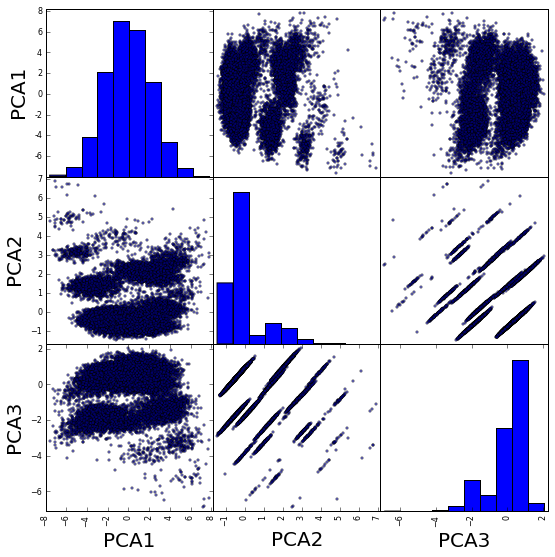

In [46]:
pd.tools.plotting.scatter_matrix(pca_df[['PCA1', 'PCA2', 'PCA3']], figsize = [9, 9]);

That is some weird blobbing of the data! The second component is highly weight by the barons and inhibs, integer data, which is creating the blobbing.

Now that we have the principal components, we can try modeling again. First, let's create our list of PCA features.

In [51]:
na_pca_dfs = [pca_lol_df(x, scalar_col) for x in na_timelines_df]
important_col_pca = ['PCA{0}'.format(x) for x in range(1,7)]
important_col_pca.extend(['first_baron', 'first_inhib'])
important_col_pca

['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'first_baron', 'first_inhib']

Now that we have our PCA columns, we can run the prediction.

In [53]:
def cross_validate_pca(cur_df, feature_col):
    return cross_validation.cross_val_score(better_forest, cur_df[feature_col], cur_df['winner'], cv=3, n_jobs = 2)
pca_scores = [cross_validate_pca(x, important_col_pca) for x in na_pca_dfs]
unreduced_scores = [cross_validate_pca(x, important_col) for x in na_timelines_df]

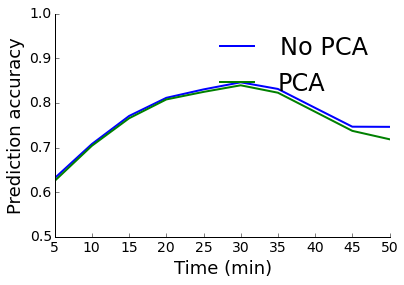

In [54]:
plt.figure(figsize = [8, 6])
plt.plot(time_indices, np.mean(unreduced_scores, 1), label = 'No PCA')
plt.plot(time_indices, np.mean(pca_scores, 1), label = 'PCA')
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)')
plt.ylabel('Prediction accuracy')
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend(frameon=False);

The people who said random forests are resilient to multicollinearity were right! We get the same prediction accuracy with PCA as we do without it.

<a id='champions'></a>
## Can the random forest detect champion interaction?

When I parsed the game data, I recorded which champions each team were playing. I wondered if the random forest would be able to tell me if certain champions were better than others, or if combinations of champions would increase predictability. So I made a function to create features showing which champions were on each team.

In [57]:
champ_timelines_df = na_timelines_df
champ_timelines_df = feature_calc.binarize_champions( champ_timelines_df )

There are a lot more features, so we need to create a new list of features for the model.

In [58]:
col_names = champ_timelines_df[0].columns
champ_col = np.array([x for x in col_names if x not in
             ['winner', 'game_length', 'blue_0', 'blue_1', 'blue_2', 'blue_3', 'blue_4',
              'red_0', 'red_1', 'red_2', 'red_3', 'red_4', 'matchId', 'utctimestamp'] ])
num_features = np.size(champ_col)

Given the much larger number of features, I decided to make a larger forest, with both more and deeper trees. Then I ran the prediction and plotted it.

In [60]:
champ_forest = RandomForestClassifier(n_estimators=200, max_depth=30,
                                      min_samples_split=20, max_features='sqrt')

def cross_validate_champ(cur_df):
    return cross_validation.cross_val_score(champ_forest, cur_df[champ_col],
                                            cur_df['winner'], cv=3, n_jobs = 2)

champ_scores = list(map( cross_validate_champ, champ_timelines_df ))

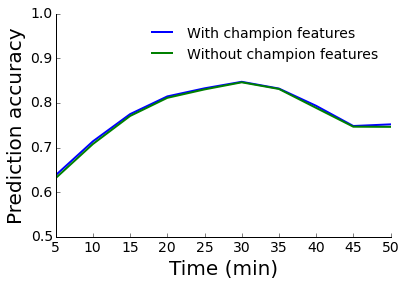

In [61]:
plt.plot(time_indices, np.mean(champ_scores, 1), label = 'With champion features')
plt.plot(time_indices, np.mean(unreduced_scores, 1), label = 'Without champion features')
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)')
plt.ylabel('Prediction accuracy')
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend(fontsize=14, frameon=False);

There is an ever-so-slight improvement in performance based on the champion information. It looks like once the game starts, the conditions of the game matter more than which champions are playing.

<a id='naivebayes'></a>
## Naive Bayes:
Finally, I wanted to see how other models would perform, so I decided to look at Naive Bayes. I made a simple predictor using the "Gaussian" features of gold, kill, etc. differences.

In [62]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
bayes_col = ['gold_diff', 'gold_diff_diff', 'kill_diff', 'tower_diff',
       'square_gold_diff', 'kill_diff_diff', 'drag_diff',
       'tower_diff_diff', 'red_inhibs','red_barons', 'blue_barons']
def nb_score(cur_df,):
    gnb.fit(cur_df[bayes_col], cur_df['winner'])
    return gnb.score(cur_df[bayes_col], cur_df['winner'])

bayes_scores = list(map(nb_score, na_timelines_df ))

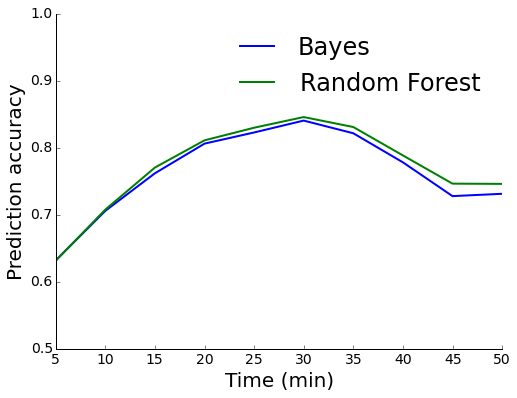

In [65]:
plt.figure(figsize = [8, 6])
plt.plot(time_indices, bayes_scores, label = 'Bayes')
plt.plot(time_indices, np.mean(unreduced_scores, 1), label = 'Random Forest')
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)')
plt.ylabel('Prediction accuracy')
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend(frameon=False);

Naive Bayes is almost as good as random forests, and a whole lot faster! I have a feeling this dataset is a bit too simple for random forests to gain an edge of Naive Bayes.

## Conclusions

This will probably be my last notebook using League of Legends data for a while. It was fun learning about random forests using a game I cared about. Here are some simple take home ideas:

1. Optimize your machine learning models
2. Skill makes the game go faster
3. Dragons don't matter